In [32]:

from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import NuSVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import time
from numba import prange
import matplotlib.pyplot as plt
%matplotlib inline


In [33]:
MODELS = {DecisionTreeRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, NuSVR,
          LinearRegression, BayesianRidge, KNeighborsRegressor, XGBRegressor, XGBRFRegressor, MLPRegressor,
          ElasticNet, SGDRegressor, KernelRidge, LassoLars, Lasso, LinearSVR, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor}


In [34]:
housing = pd.read_csv(r'./datasets/kc_house_data.csv')
quality = pd.read_csv(r'./datasets/winequality-red.csv')


In [35]:
housing


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [36]:
quality


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [37]:
housing = housing.dropna()
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [38]:
quality.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [39]:
def metrics(tt, tp, vt, vp, model,
            time=None): return {
    "model": model,
    'time': time,
    "mse": (mean_squared_error(tt, tp),
            mean_squared_error(vt, vp)),
    'r2': (r2_score(tt, tp),
           r2_score(vt, vp))
}


def create_model(X, y, model_name,
                 time_it: bool = False):
    model = model_name()
    if time_it == True:
        begin = time.perf_counter()
        model.fit(X, y)
        end = time.perf_counter()
        return (model, end - begin)
    return model.fit(X, y)


def get_metrics(model_name):
    Xt, Xv, yt, yv = train_test_split(
        housing_X, housing_y, train_size=.7)
    results = create_model(Xt, yt, model_name, time_it=True)
    model, time = results[0], results[1]
    return metrics(
        yt, model.predict(Xt), yv,
        model.predict(Xv), model_name, time)


def get_results(X, y, models):
    results = []
    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        res = executor.map(get_metrics, models)
        results = [i for i in res if i]
    return results


def plot_results(results: 'list[dict]'):
    y = [i['model'] for i in results]
    pos = np.arange(len(y))
    plt.barh(pos, [i['mse'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Validation')
    plt.show()
    plt.barh(pos, [i['mse'][0] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Traning')
    plt.show()
    plt.barh(pos, [i['time'] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Time')
    plt.show()
    plt.barh(pos, [i['r2'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('R2')
    plt.show()
    plt.barh(pos, [i['time'] * i['mse'][1] * -
             1 for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Efficiency (Higher the better)')
    plt.show()
    plt.barh(pos, [-1 * i['time'] * i['mse'][1] / (i['mse']
             [1] - i['mse'][0]) for i in results], align='center')
    plt.yticks(pos, y)
    plt.title('Weighted Efficiency (Higher the better)')
    plt.show()


In [40]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [41]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [42]:
housing_y


0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64

In [43]:
housing_X = MinMaxScaler().fit_transform(
    RobustScaler().fit_transform(housing_X))


In [44]:
housing_results = get_results(
    housing_X, housing_y, MODELS)


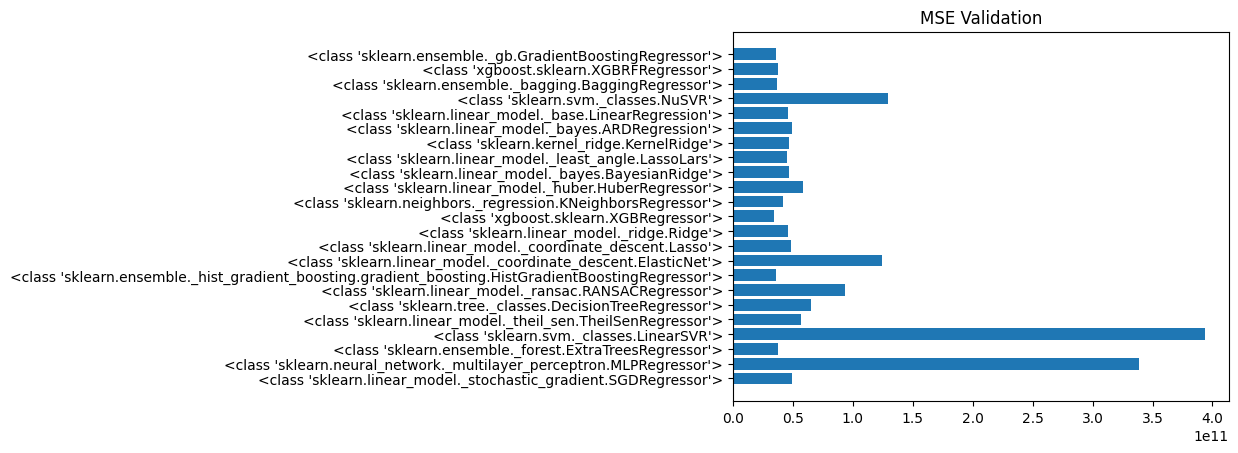

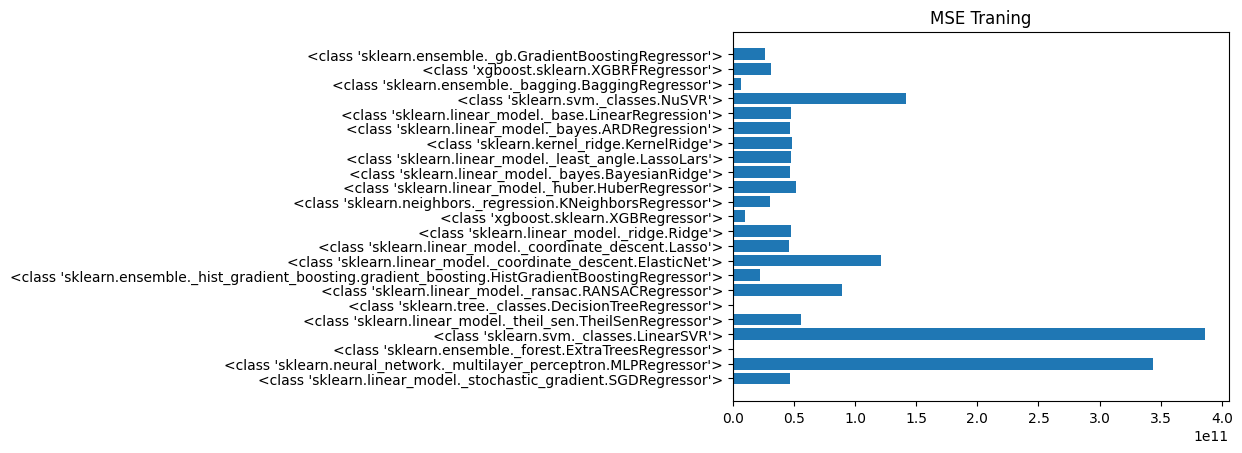

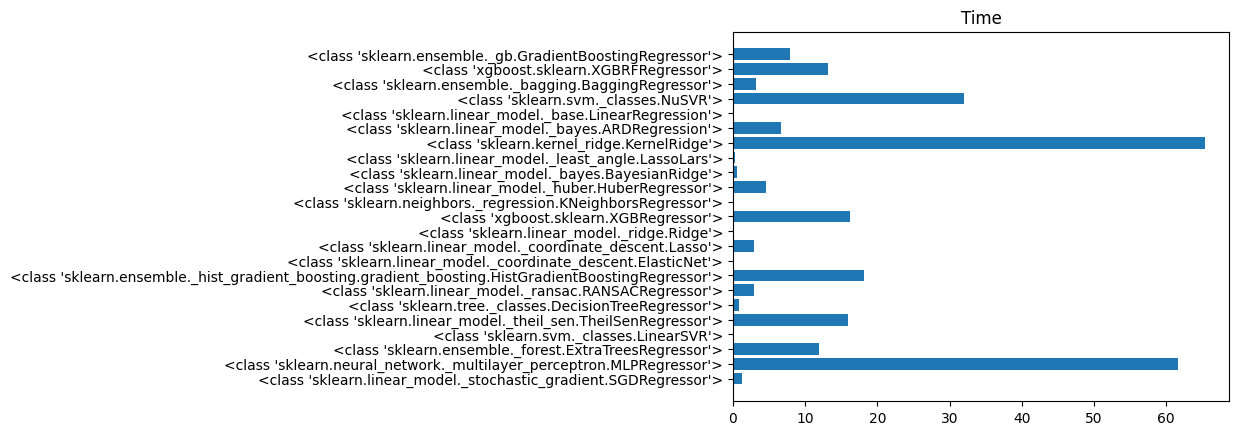

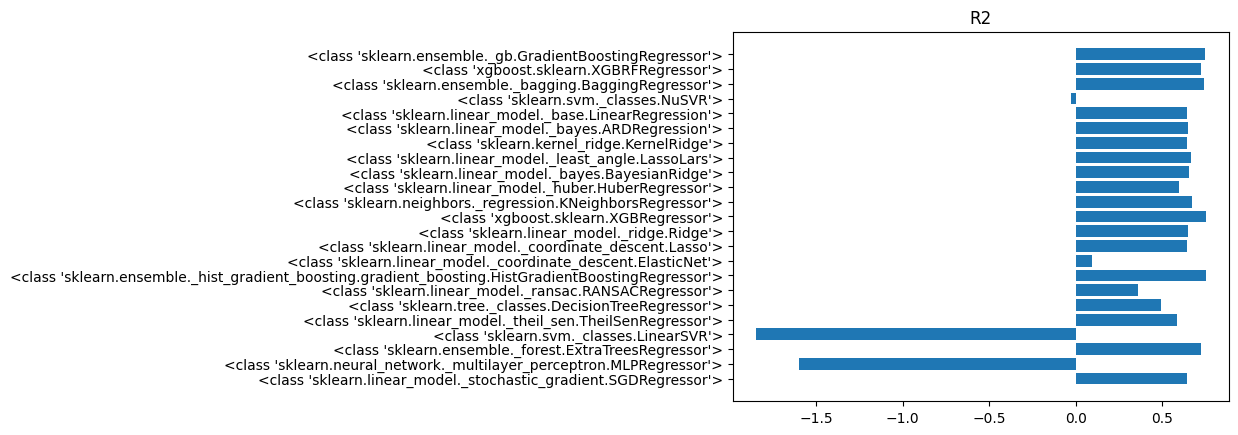

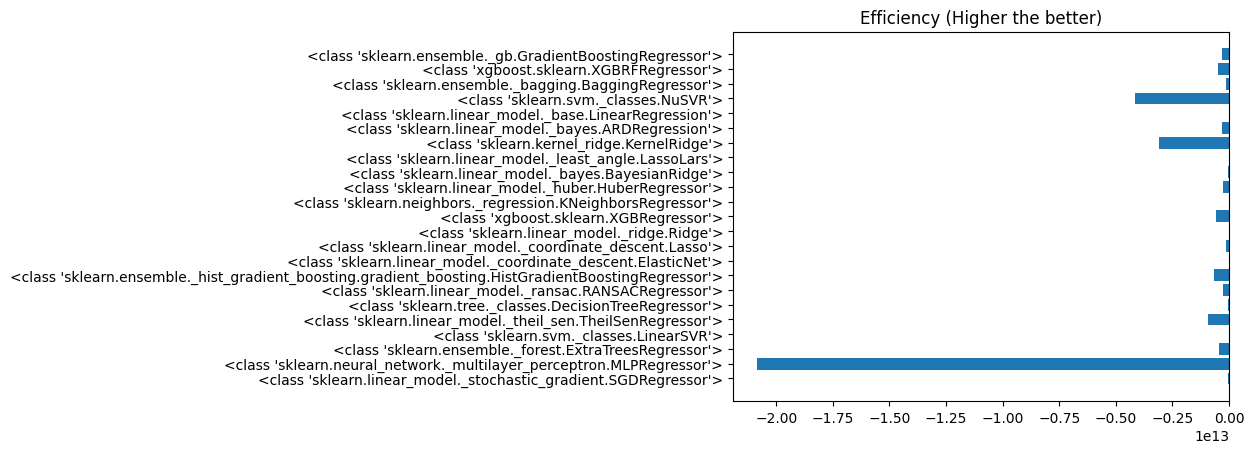

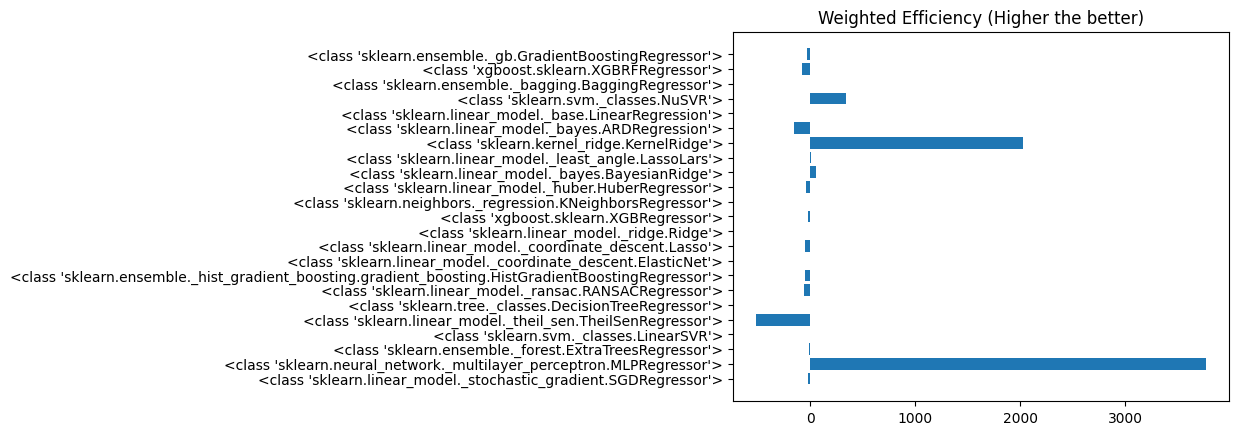

In [ ]:
plot_results(housing_results)


In [ ]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [ ]:
# import numpy as np
# import pandas as pd
# from numba import prange
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import RobustScaler, MinMaxScaler
# from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
# from sklearn.svm import SVR, NuSVR, LinearSVR
# from sklearn.neural_network import MLPRegressor
# from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
# from xgboost import XGBRegressor, XGBRFRegressor
# from sklearn.impute import KNNImputer
# from time import perf_counter
# from copy import deepcopy


# class VGBRegressor(object):
#     def __init__(
#         self,
#         *,
#         learning_rate: float = 0.1,
#         n_estimators: int = 100,
#         custom_loss=None,
#         early_stopping: bool = False,
#         early_stopping_min_delta: float = 0.001,
#         early_stopping_patience: int = 10,
#         complexity: bool = False,
#         custom_models: list = None
#     ):
#         # self.learning_rate = learning_rate
#         # self.n_estimators = n_estimators
#         # self.custom_loss = custom_loss
#         # self.early_stopping = early_stopping
#         # self._X = None
#         # self._y = None
#         # if custom_models:
#         #     self._models = custom_models
#         # else:
#         #     if complexity:
#         #         self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, ExtraTreesRegressor,
#         #                         ElasticNet, LassoLars, Lasso, GradientBoostingRegressor, HistGradientBoostingRegressor,
#         #                         BaggingRegressor, SVR, NuSVR, XGBRegressor, XGBRFRegressor, SGDRegressor, KernelRidge, MLPRegressor,
#         #                         Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor)
#         #     else:
#         #         self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor,
#         #                         ElasticNet, LassoLars, Lasso, SGDRegressor, BaggingRegressor,
#         #                         Ridge, RANSACRegressor,)
#         self._ensemble = []

#     def _metrics(self, vt, vp, model, time=None):
#         if self.custom_loss_metrics:
#             return {'model': model, 'time': time, 'loss': self.custom_loss_metrics(vt, vp)}
#         return {"model": model, "time": time, "loss": mean_absolute_error(vt, vp)}

#     def _create_model(self, X, y, model_name, time_it: bool = False):
#         # model = Pipeline([
#         #     ('scaler1', RobustScaler()),
#         #     ('scaler2', MinMaxScaler()),
#         #     ('model', model_name())
#         # ])
#         model = model_name()
#         if time_it:
#             begin = perf_counter()
#             model.fit(X, y)
#             end = perf_counter()
#             return (model, end - begin)
#         return (model.fit(X, y), None)

#     def _get_metrics(self, model_name):
#         Xt, Xv, yt, yv = train_test_split(self._X, self._y)
#         results = self._create_model(Xt, yt, model_name, time_it=False)
#         model, time = results[0], results[1]
#         return self._metrics(yv,
#                              model.predict(Xv), model, time)

#     def _get_results(self, X, y) -> list:
#         results = []
#         try:
#             self._X = MinMaxScaler().fit_transform(
#                 RobustScaler().fit_transform(X)
#             )
#         except Exception:
#             self._X = MinMaxScaler().fit_transform(
#                 RobustScaler().fit_transform(
#                     KNNImputer(weights='distance').fit_transform(X)
#                 )
#             )
#         self._y = y
#         with ThreadPoolExecutor(max_workers=len(self._models)) as executor:
#             res = executor.map(self._get_metrics, self._models)
#             # for i in
#             results = [i for i in res if i]
#         return results
#         for i in self._models:
#             try:
#                 results.append(self._get_metrics(X, y, i))
#             except Exception:
#                 pass
#         return results

#     def fit(
#         self, X_train, y_train,
#         early_stopping: bool = False,
#         early_stopping_min_delta: float = 0.001,
#         early_stopping_patience: int = 10,
#         custom_models: list = None,
#         learning_rate: float = 0.05,
#         n_estimators: int = 50,
#         warm_start: bool = False,
#         complexity: bool = False,
#         custom_loss_metrics: object = False,
#     ):
#         if custom_models:
#             self._models = custom_models
#         self.custom_loss_metrics = custom_loss_metrics
#         self.learning_rate = learning_rate
#         self.n_estimators = n_estimators
#         self.early_stopping = early_stopping
#         self.early_stopping_min_delta = early_stopping_min_delta
#         self.early_stopping_patience = early_stopping_patience
#         if custom_models:
#             self._models = custom_models
#         else:
#             if complexity:
#                 self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, ExtraTreesRegressor,
#                                 ElasticNet, LassoLars, Lasso, GradientBoostingRegressor, HistGradientBoostingRegressor,
#                                 BaggingRegressor, NuSVR, XGBRegressor, XGBRFRegressor, SGDRegressor, KernelRidge, MLPRegressor,
#                                 Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor)
#             else:
#                 self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor,
#                                 ElasticNet, LassoLars, Lasso, SGDRegressor, BaggingRegressor,
#                                 Ridge, ARDRegression, RANSACRegressor,)
#         X_train = deepcopy(X_train)
#         # base model: mean
#         # computer residuals: y - y hat
#         # for n_estimators: a) y = prev residuals && residuals * learning rate
#         # add early stopping
#         # restore best weights
#         # ada boost and adaptive scaling for learning rates

#         preds = pd.DataFrame(
#             data={'yt': y_train, 'p0': np.full((len(y_train)), y_train.mean(skipna=True))})
#         residuals = pd.DataFrame(
#             data={'r0': y_train - y_train.mean(skipna=True)})
#         errors = []
#         if not early_stopping:
#             if warm_start:
#                 for i in prange(1, self.n_estimators + 1):
#                     y = residuals[f'r{i - 1}']
#                     results = self._get_results(X_train, y)
#                     min_loss = min(results, key=lambda x: x.get(
#                         "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
#                     min_model = [i['model']
#                                  for i in results if min_loss >= i['loss']][0]
#                     preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
#                         X_train) * self.learning_rate
#                     residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
#                     if i % 3 == 0:
#                         X_train[f"r{i}"] = residuals[f'r{i}'].copy()
#                     try:
#                         errors.append(mean_squared_error(
#                             preds['yt'], preds[f'p{i}']))
#                     except Exception:
#                         df = pd.concat(
#                             [preds['yt'], preds[f'p{i - 1}']], axis=1).dropna()
#                         errors.append(mean_squared_error(
#                             df['yt'], df[f"p{i - 1}"]))
#                     self._ensemble.append(min_model)
#             else:
#                 for i in prange(1, self.n_estimators + 1):
#                     y = residuals[f'r{i - 1}']
#                     results = self._get_results(X_train, y)
#                     min_loss = min(results, key=lambda x: x.get(
#                         "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
#                     min_model = [i['model']
#                                  for i in results if min_loss >= i['loss']][0]
#                     preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
#                         X_train) * self.learning_rate
#                     residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
#                     errors.append(mean_squared_error(
#                         preds['yt'], preds[f'p{i}']))
#                     self._ensemble.append(min_model)
#         else:
#             return "TODO"
#         min_error = min(errors)
#         min_error_i = [i for i in prange(len(errors)) if errors[i]==min_error][0]
#         self._ensemble, errors = self._ensemble[:min_error_i], errors[:min_error_i]
#         residuals = residuals[:len(errors)]
#         return self._ensemble, (residuals, errors)
from VGBRegressor import VGBRegressor

In [ ]:
model = VGBRegressor()


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
models = model.fit(quality_X, quality_y,)

In [ ]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

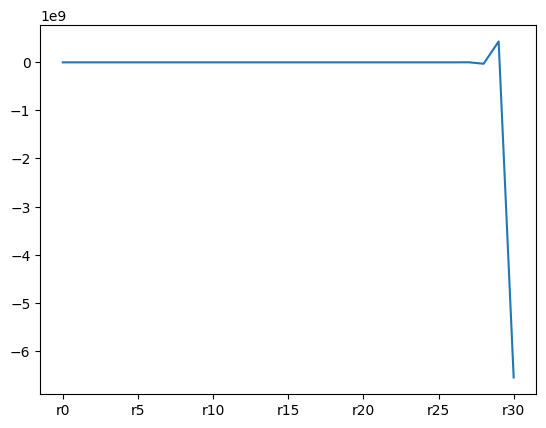

In [ ]:
res.mean().plot()


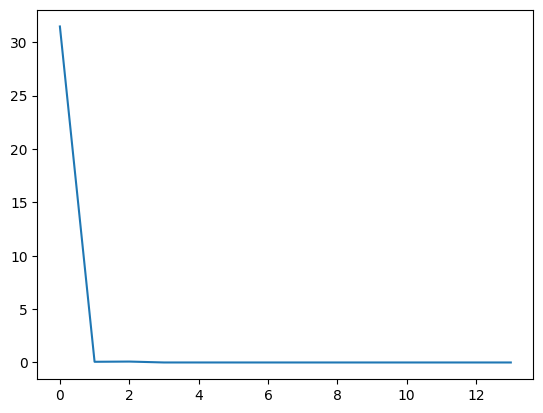

In [ ]:
plt.plot(errors[:])


In [ ]:
errors, models[0]

([31.472775222817496,
  0.06479016362326817,
  0.08576189734155398,
  0.0007369820521564605,
  0.00025583125335200814,
  4.644744297810985e-06,
  8.23159674512709e-07,
  2.3427942525998548e-08,
  2.8104684642066736e-09,
  1.0614818419425791e-10,
  1.0021868376434853e-11,
  4.539829092697845e-13,
  3.702114489599868e-14,
  1.9157114751694243e-15],
 BaggingRegressor())

In [ ]:
model = VGBRegressor()
models = model.fit(quality_X, quality_y, n_estimators=50,
                   complexity=True,)


In [ ]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

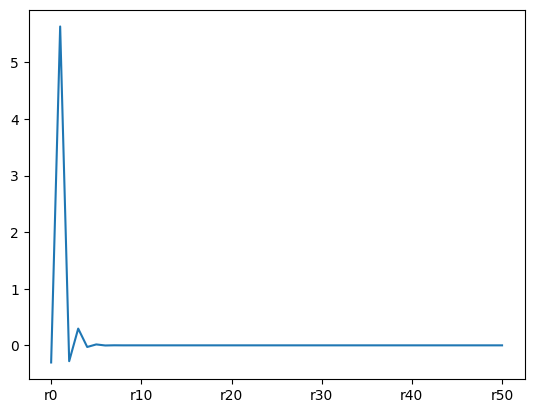

In [ ]:
res.mean().plot()

NameError: name 'prange' is not defined

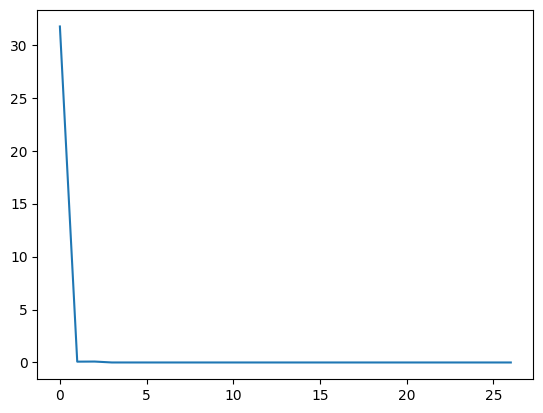

In [ ]:
plt.plot(errors[:])
plt.plot(errors[:[i for i in prange(len(errors))
         if errors[i] == min(errors)][0]-1]);

In [ ]:
errors, models[0]


([73765757658.13892,
  61210410392.20553,
  2146350.0259547303,
  151570193.10306084,
  311719.3219280235,
  413968.72754354,
  3605.3472782146832,
  1236.983726666193,
  21.791320226858808,
  3.608916916767961,
  0.10783511882617745,
  0.012410834435195845,
  0.0004835215995559306,
  4.448400031891909e-05,
  2.053254166991807e-06,
  1.6285542412164366e-07,
  8.148237611197517e-09,
  6.094975350440534e-10,
  3.298919386630343e-11,
  2.311671148578863e-12,
  1.3192725300875326e-13,
  8.869894812176151e-15,
  5.321190982773974e-16],
 [KNeighborsRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  RANSACRegressor(),
  Lasso(),
  ARDRegression(),
  DecisionTreeRegressor(),
  BayesianRidge(),
  KNeighborsRegressor(),
  KNeighborsRegressor(),
  BaggingRegressor(),
  KNeighborsRegressor(),
  BayesianRidge(),
  Ridge(),
  BayesianRidge(),
  LinearRegression(),
  RANSACRegressor()])

In [ ]:
model = VGBRegressor() # 19.6

In [ ]:
models = model.fit(housing_X, housing_y,)

In [ ]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

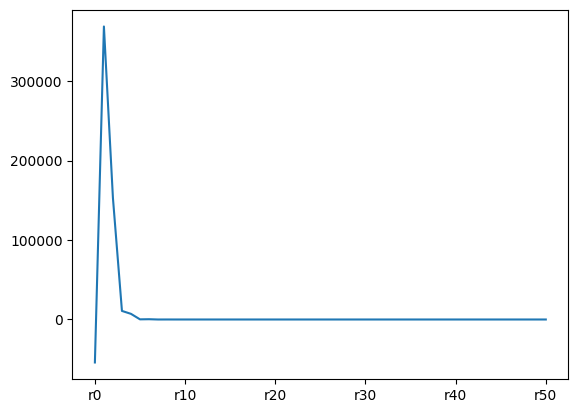

In [ ]:
res.mean().plot()

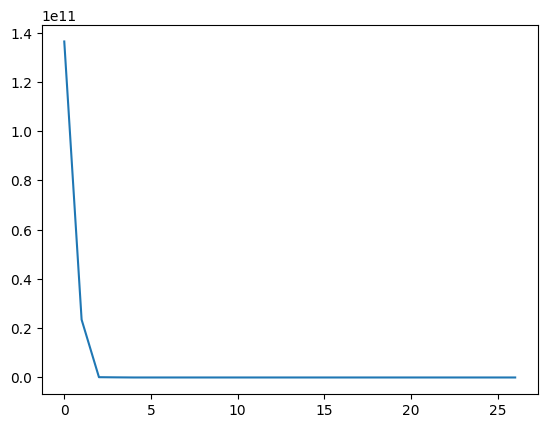

In [ ]:
plt.plot(errors)

In [ ]:
errors, models


([136403248939.71501,
  23476716406.218445,
  119010481.42060973,
  50875459.36291999,
  46579.12287127366,
  121117.30552794317,
  121.4898532960654,
  318.4882764026162,
  1.899905067441084,
  0.9205904642852967,
  0.013507211328023143,
  0.0028881900966724306,
  7.201262559741244e-05,
  9.673760723041453e-06,
  3.358818017962371e-07,
  3.402583158325306e-08,
  1.4588255095196135e-09,
  1.2392127334094819e-10,
  6.082039464634428e-12,
  4.622391072909931e-13,
  2.4744045439682567e-14,
  1.7499107523345385e-15,
  9.599353055954654e-17,
  6.154643153924666e-18,
  3.869198435417344e-19,
  2.4685555039018272e-20,
  1.7144843540246092e-21],
 [BaggingRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionT